# Lecture 19 - Inverse Problems/Model Calibration: Classical Approaches

## Objectives

+ Appreciate the ubiquitousness of inverse problems through examples.
+ Formulate inverse problems as optimization problems.
+ Remember the adjoint method for dynamical systems.
+ Demonstrate approach by applying it to the calibration of a reaction kinetics problem.
+ Highlight the shortcomings of the classical approach to inverse problems.

## Readings

+ These notes.

In [3]:
import numpy as np
import math
import scipy.stats as st
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import design
import warnings
warnings.filterwarnings('ignore')

## Definition of Inverse Problems

Suppose that you have a model (any model really) that predicts a quantity of interest.
Let's assume that this model has parameters that you do not know.
These parameters could be simple scalars (mass, spring constant, dumping coefficients, etc.) or it could be also be functions (initial conditions, boundary values, spatially distributed constitutive relations, etc.)
In the case of the latter, we assume that you have already reduced the dimensionality of the parameterization with, for example, the Karhunen-Lo\`eve expansion (see [Lecture 12](./handout_12.ipynb)).
Let's denote all these parameters with the vector $x$.
Assume that:
$$
x\in\mathcal{X} \subset\mathbb{R}^d.
$$
Now, let's say we perform an experiment that measures a *noisy* vector:
$$
y\in\mathcal{Y}\subset \mathbb{R}^m.
$$
Assume that, you can use your model *model* to predict $y$.
It does not matter how complicated your model is.
It could be a system of ordinary differential or partial differential equations, or something more complicated.
If it predicts $y$, you can always think of it as a function from the unknown parameter space $\mathcal{X}$ to the space of $y$'s, $\mathcal{Y}\subset\mathbb{R}^m$.
That is, you can think of it as giving rise to a function:
$$
f :\mathcal{X} \rightarrow \mathcal{Y}.
$$

The **inverse problem**, otherwise known as the **model calibration** problem is to find the ``best`` $x\in\mathcal{X}$ so that:
$$
f(x) \approx y.
$$

## Formulation of Inverse Problems as Optimization Problems
Saying that $f(x)\approx y$ is not an exact mathematical statement.
What does it really mean for $f(x)$ to be close to $y$?
To quantify this, let us introduce a *loss metric*:
$$
\ell: \mathcal{Y}\times\mathcal{Y}\rightarrow \mathbb{R},
$$
such that $\ell(f(x),y)$ is how much our prediction is off if we chose the input $x\in\mathcal{X}$.
Equiped with this loss metric, we can formulate the mathematical problem as:
$$
\min_{x\in\mathcal{X}} \ell(f(x),y).
$$

### The Square Loss
The choice of the metric is somewhat subjective (it depends on what it means to be wrong in your problem).
However, a very common assumption is that to take the *square loss*:
$$
\ell(f(x), y) = \frac{1}{2}\parallel f(x) - y\parallel_2^2 = \frac{1}{2}\sum_{i=1}^m\left(f_i(x)-y_i\right)^2.
$$
For this case, the inverse problem can be formulated as:
$$
\min_{x\in\mathcal{X}}\frac{1}{2}\parallel f(x) - y\parallel_2^2.
$$

### Solution Methodologies
We basically have to solve an optimization problem.
For the square loss function, if $f(x)$ is linear, then you get the classic least squares problem which has a known solution.
Otherwise, you get what is known as *generalized least squares*.
There are many algorithms that you could use this problem.
Several are implemented in [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html).
If you are able to implement (and you should) your model as a simple python function, then you can use them.
The absolutely, essential thing that you need to provide to these methods is the function they are optimizing, i.e.,
$$
L(x,y) = \ell(f(x),y).
$$

### Numerical Estimation of Derivatives
Most of the methods in [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) require the specification of the gradient:
$$
\nabla L(x,y) = \left(\frac{\partial L(x)}{\partial x_1},\dots,\frac{\partial L(x)}{\partial x_d}\right)\in\mathbb{R}^d.
$$
If you do not supply this function, then ``scipy`` will approximate it numerically with a [first order finite differences](https://en.wikipedia.org/wiki/Numerical_differentiation).
The approximation they use is:
$$
\frac{\partial L(x,y)}{\partial x_i} \approx \frac{L(x + he_i,y) - L(x,y)}{h},
$$
where $e_i\in\mathbb{R}^d$ is the $i$-th standard orthonormal unit vector of $\mathbb{R}^d$ and $h$ is a small number, e.g., $h=10^{-6}$.
This computational costs $d$ times the evaluation of the objective function.
Thus, it is impractical for expensive models and high-dimensions.'

## Example: Catalytic Conversion of Nitrate to Nitrogen

This is Example 3.1 of [(Tsilifis, 2014)](http://arxiv.org/abs/1410.5522).

Consider the catalytic
conversion of nitrate ($\mbox{NO}_3^-$) to nitrogen ($\mbox{N}_2$) and other
by-products by electrochemical means.
The mechanism that is followed is complex and not well understood.
The experiment of [(Katsounaros, 2012)](http://www.sciencedirect.com/science/article/pii/S0013468612005208) confirmed the
production of nitrogen ($\mbox{N}_2$), ammonia
($\mbox{NH}_3$), and nitrous oxide ($\mbox{N}_2\mbox{O}$) as final products
of the reaction, as well as the intermediate production of nitrite ($\mbox{NO}_2^-$).
The data are reproduced in [Comma-separated values](https://en.wikipedia.org/wiki/Comma-separated_values) (CSV) and stored in
[data/catalysis.csv](data/catalysis.csv).
The time is measured in minutes and the conentrations are measured in $\mbox{mmol}\cdot\mbox{L}^{-1}$.
Let's load the data into this notebook using the [Pandas](http://pandas.pydata.org) Python module:

In [4]:
# If this fails, you haven't uploaded "catalysis.csv".
# Repeat 11 of the instructions.
import pandas as pd
catalysis_data = pd.read_csv('catalysis.csv', index_col=0)
catalysis_data

,NO3,NO2,N2,NH3,N2O
Time,,,,,
0,500.00,0.00,0.00,0.00,0.00
30,250.95,107.32,18.51,3.33,4.98
60,123.66,132.33,74.85,7.34,20.14
90,84.47,98.81,166.19,13.14,42.10
120,30.24,38.74,249.78,19.54,55.98
150,27.94,10.42,292.32,24.07,60.65
180,13.54,6.11,309.50,27.26,62.54


Let's visualize the data using [Matplotlib](http://matplotlib.org):

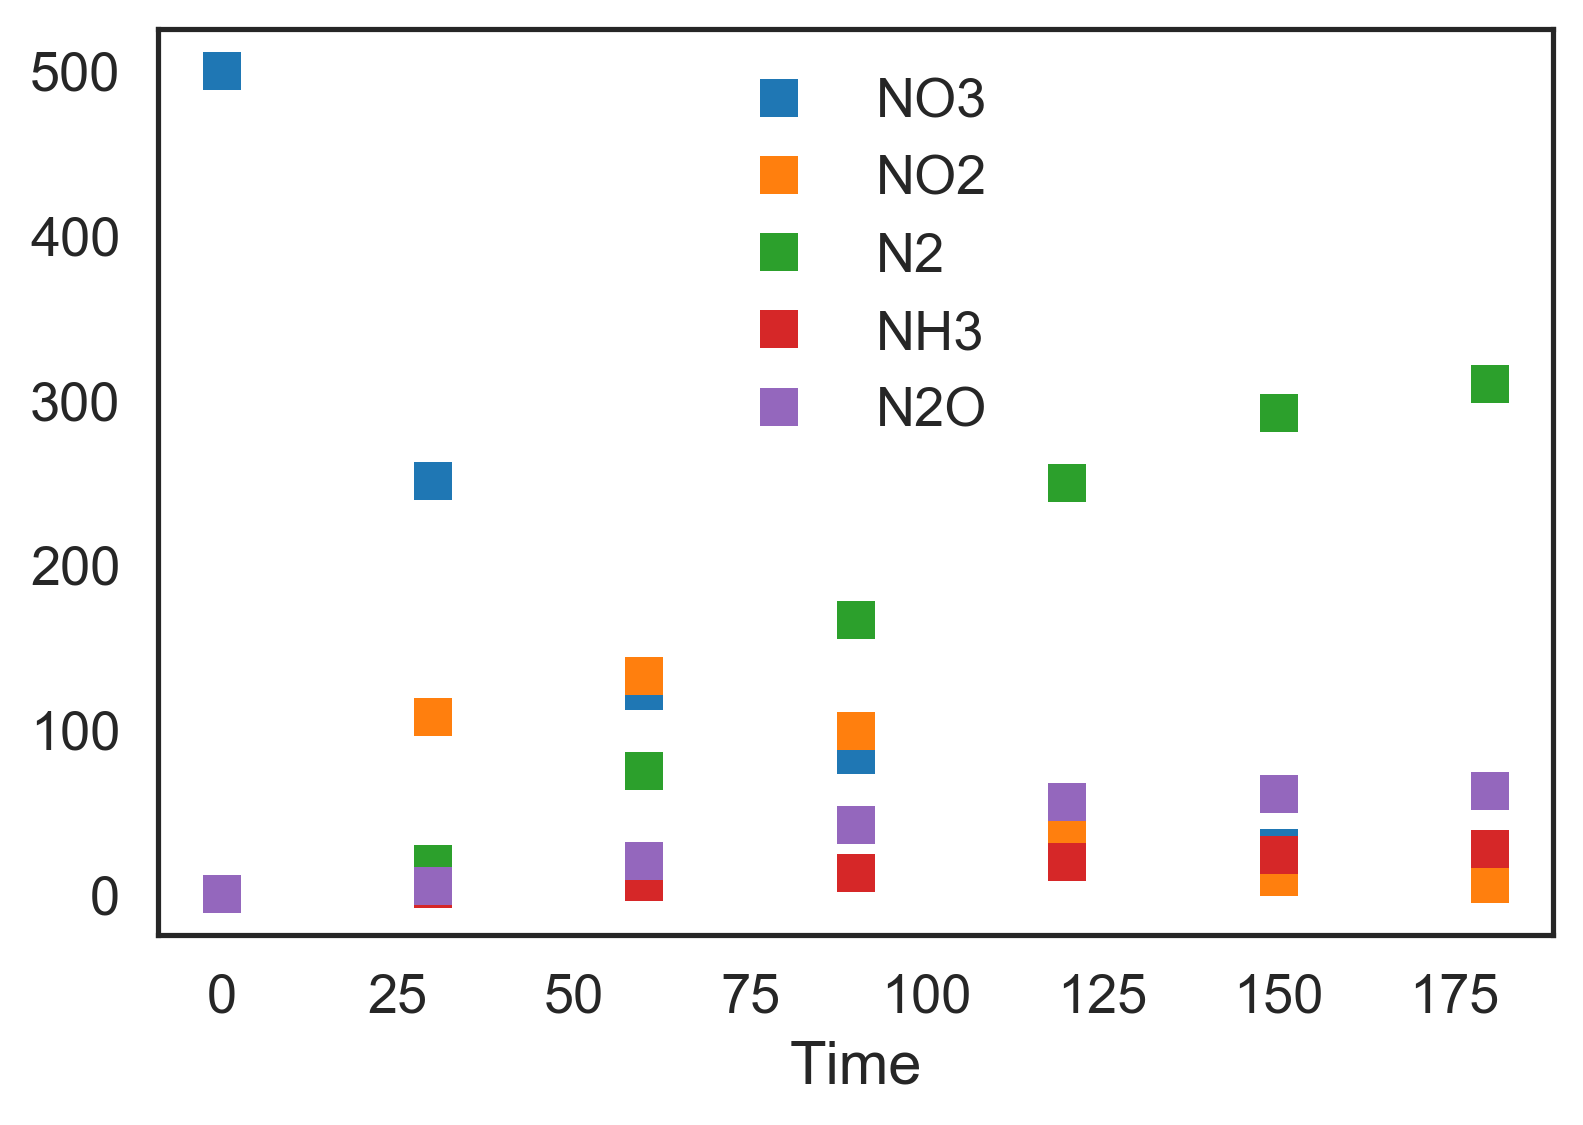

In [5]:
catalysis_data.plot(style='s')

The theory of catalytic reactions guarantees that the total mass must be conserved.
However, this is not the case in our dataset:

In [6]:
catalysis_data.sum(axis=1)

Time
0      500.00
30     385.09
60     358.32
90     404.71
120    394.28
150    415.40
180    418.95
dtype: float64

This inconsistency suggests the existence of an intermediate unobserved reaction product X.
[(Katsounaros, 2012)](http://www.sciencedirect.com/science/article/pii/S0013468612005208) suggested that the following reaction path shown in the following figure.

![](scheme.png "Reaction Scheme")

The dynamical system associated with the reaction is:
$$
\begin{array}{cc}
\frac{d \left[\mbox{NO}_3^-\right]}{dt} &= -k_1\left[\mbox{NO}_3^-\right], \\
\frac{d\left[\mbox{NO}_2^-\right]}{dt} &= k_1\left[\mbox{NO}_3^-\right] - (k_2 + k_4 +
k_5)[\mbox{NO}_2^-], \\
\frac{d \left[\mbox{X}\right]}{dt} &= k_2 \left[\mbox{NO}_2^-\right] - k_3 [X],\\
\frac{d \left[\mbox{N}_2\right]}{dt} &= k_3 \left[\mbox{X}\right], \\
\frac{d \left[\mbox{NH}_3\right]}{dt} &= k_4 \left[\mbox{NO}_2^-\right],\\
\frac{d \left[\mbox{N}_2O\right]}{dt} &= k_5 \left[\mbox{NO}_2^-\right],
\end{array}
$$
where $[\cdot]$ denotes the concentration of a quantity, and
$k_i > 0$, $i=1,...5$ are the *kinetic rate constants*.

### Formulation of the Inverse Problem

#### Step 1: Making our life easier by simplifying the notation
Note that this is actually a linear system.
To simplify our notation, let's define:
$$
\begin{array}{ccc}
z_1 &:=& \left[\mbox{NO}_3^-\right],\\
z_2 &:=& \left[\mbox{NO}_2^-\right],\\
z_3 &:=& \left[\mbox{X}\right],\\
z_4 &:=& \left[\mbox{N}_2\right],\\
z_5 &:=& \left[\mbox{NH}_3\right],\\
z_6 &:=& \left[\mbox{N}_2O\right],
\end{array}
$$
the vector:
$$
z = (z_1,z_2,z_3,z_4,z_5,z_6),
$$
and the matrix:
$$
A(k_1,\dots,k_5) = \left(\begin{array}{cccccc}
-k_1 & 0 & 0 & 0 & 0 & 0\\
k_1 & -(k_2+k_4+k_5) & 0 & 0 & 0 & 0\\
0 & k_2 & -k_3 & 0 & 0 & 0\\
0 & 0 & k_3 & 0 & 0 & 0\\
0 & k_4 & 0 & 0 & 0 & 0\\
0 & k_5 & 0 & 0 & 0 & 0
\end{array}\right)\in\mathbb{R}^{6\times 6}.
$$
With these definitions, the dynamical system becomes:
$$
\dot{z} = A(k_1,\dots,k_5)z,
$$
with initial conditions
$$
z(0) = z_0 = (500, 0, 0, 0, 0, 0)\in\mathbb{R}^6,
$$
read directly from the experimental data.
What we are definitely going to need is a solver for this system.
That's easy.
Let's denote the solution of the system at time $t$ by:
$$
z(t;k_1,\dots,k_5).
$$

#### Step 2: Scale the unknown parameters to your best of your abilities
The constraints you have on your parameters, the better.
If you do have constraints, you would have to use constrained optimization algorithms.
The way you scale things depend on the problem.
Here we would think as follows:

+ $k_i$ has units of inverse time. It is proparly appropriate to scale it with the total time which is 180 minutes.
So, let's just multiply $k_i$ with 180. This makes the resulting variable dimensionless:
$$
\hat{x}_i = 180k_i.
$$

+ $k_i$ is positive, therefore $\hat{x_i}$ must be positive.
So, let's just work with the logarithm of $\hat{x_i}$:
$$
x_i = \log \hat{x_i} = \log 180k_i.
$$

+ define the parameter vector:
$$
x = (x_1,\dots,x_5)\in\mathcal{X} = \mathbb{R}^5.
$$

From now on, we will write
$$
A = A(x),
$$
for the matrix of the dynamical system, and
$$
z = z(t;x),
$$
for the solution at $t$ given that the parameters are $x$.

#### Step 3: Making the connection between our model and the experimental measurements
Our experimental data include measurements of everything except $z_3$ at times six (6) time instants:
$$
t_j = 30j\;\mbox{minutes},
$$
$j=1,\dots,6$.

Now, let $Y\in\mathbb{R}^{5\times 6}$ be the experimental measurements:

In [7]:
catalysis_data[1:]

,NO3,NO2,N2,NH3,N2O
Time,,,,,
30,250.95,107.32,18.51,3.33,4.98
60,123.66,132.33,74.85,7.34,20.14
90,84.47,98.81,166.19,13.14,42.10
120,30.24,38.74,249.78,19.54,55.98
150,27.94,10.42,292.32,24.07,60.65
180,13.54,6.11,309.50,27.26,62.54


You can think of the measurements as vector by flattening the matrix:
$$
y = \operatorname{vec}(Y)\in\mathbb{R}^{30}.
$$
Note that ``vec`` is the vectorization operator.

What is the connection between the solution of the dynamical system $z(t,x)$ and the experimental data?
It is as follows:
$$
\begin{array}{ccc}
z_1(30j;x) &\longrightarrow& Y_{j1},\\
z_2(30j;x) &\longrightarrow& Y_{j2},\\
z_4(30j;x) &\longrightarrow& Y_{j3},\\
z_5(30j;x) &\longrightarrow& Y_{j4},\\
z_6(30j;x) &\longrightarrow& Y_{j5},
\end{array}
$$
for $j=1,\dots,6$.

We are now ready to define a function:
$$
f:\mathcal{X} \rightarrow \mathcal{Y}=\mathbb{R}^{30}_+,
$$
as follows:
+ Define the matrix function:
$$
F:\mathcal{X} \rightarrow \mathbb{R}^{5\times 6},
$$
by:
$$
\begin{array}{ccccc}
F_{j1}(x) &=& z_1(30j;x)&\longrightarrow& Y_{j1},\\
F_{j2}(x) &=& z_2(30j;x) &\longrightarrow& Y_{j2},\\
F_{j3}(x) &=& z_4(30j;x) &\longrightarrow& Y_{j3},\\
F_{j4}(x) &=& z_5(30j;x) &\longrightarrow& Y_{j4},\\
F_{j5}(x) &=& z_6(30j;x) &\longrightarrow& Y_{j5},
\end{array}
$$
+ And flatten that function:
$$
f(x) = \operatorname{vec}(F(x))\in\mathbb{R}^{30}.
$$

Now, we have made the connection with our theoretical formulation of inverse problems crystal clear.

#### Step 4: Programming our solver and the loss function

In [8]:
import scipy.integrate

def A(x):
    """
    Return the matrix of the dynamical system.
    """
    # Scale back to the k's
    k = np.exp(x) / 180.
    res = np.zeros((6,6))
    res[0, 0] = -k[0]
    res[1, 0] = k[0]
    res[1, 1] = -(k[1] + k[3] + k[4])
    res[2, 1] = k[1]
    res[2, 2] = -k[2]
    res[3, 2] = k[2]
    res[4, 1] = k[4]
    res[5, 1] = k[3]
    return res
    

def g(z, t, x):
    """
    The right hand side of the dynamical system.
    """
    return np.dot(A(x), z)


# The initial conditions
z0 = np.array([500., 0., 0., 0., 0., 0.])


# The times at which we need the solution (experimental times)
t_exp = np.array([30. * j for j in range(1, 7)])

# The experimental data as a matrix
Y = catalysis_data[1:].get_values()

# The experimental as a vector
y = Y.flatten()

# The full solution of the dynamical system
def Z(x, t):
    """
    Returns the solution for parameters x at times t.
    """
    return scipy.integrate.odeint(g, z0, t, args=(x,))


# The matrix function F (matches to Y)
def F(x, t):
    res = Z(x, t)
    return np.hstack([res[:, :2], res[:, 3:]])
    

# The function f (matches to y)
def f(x, t):
    return F(x, t).flatten()


# Finally, the loss function that we need to minimize over x:
def L(x, t, y):
    return 0.5 * np.sum((f(x, t) / 500. - y / 500.) ** 2) # We scale for numerical stability

Let's optimize.

In [9]:
import scipy.optimize

# Initial guess for x
x0 = np.random.randn(5)
#x0 = 10 * np.ones(5)

# Optimize
res = scipy.optimize.minimize(L, x0, args=(t_exp, y))

print res

      fun: 0.16530885910110074
 hess_inv: array([[  5.29984247,   1.23728393,  -6.19577632,  -1.62140745,
         -2.09536553],
       [  1.23728393,  13.94690715, -14.19736691,   5.40564942,  -3.5170977 ],
       [ -6.19577632, -14.19736691,  30.52984149,   3.14237383,
         18.42146871],
       [ -1.62140745,   5.40564942,   3.14237383,  20.0120062 ,
          4.78235541],
       [ -2.09536553,  -3.5170977 ,  18.42146871,   4.78235541,
         86.64880487]])
      jac: array([ -1.19954348e-06,   1.57952309e-06,  -5.37186861e-06,
         2.87778676e-06,   1.70990825e-06])
  message: 'Optimization terminated successfully.'
     nfev: 273
      nit: 36
     njev: 39
   status: 0
  success: True
        x: array([ 1.9255556 ,  2.01913566,  1.42456019,  0.26517072, -0.52575212])


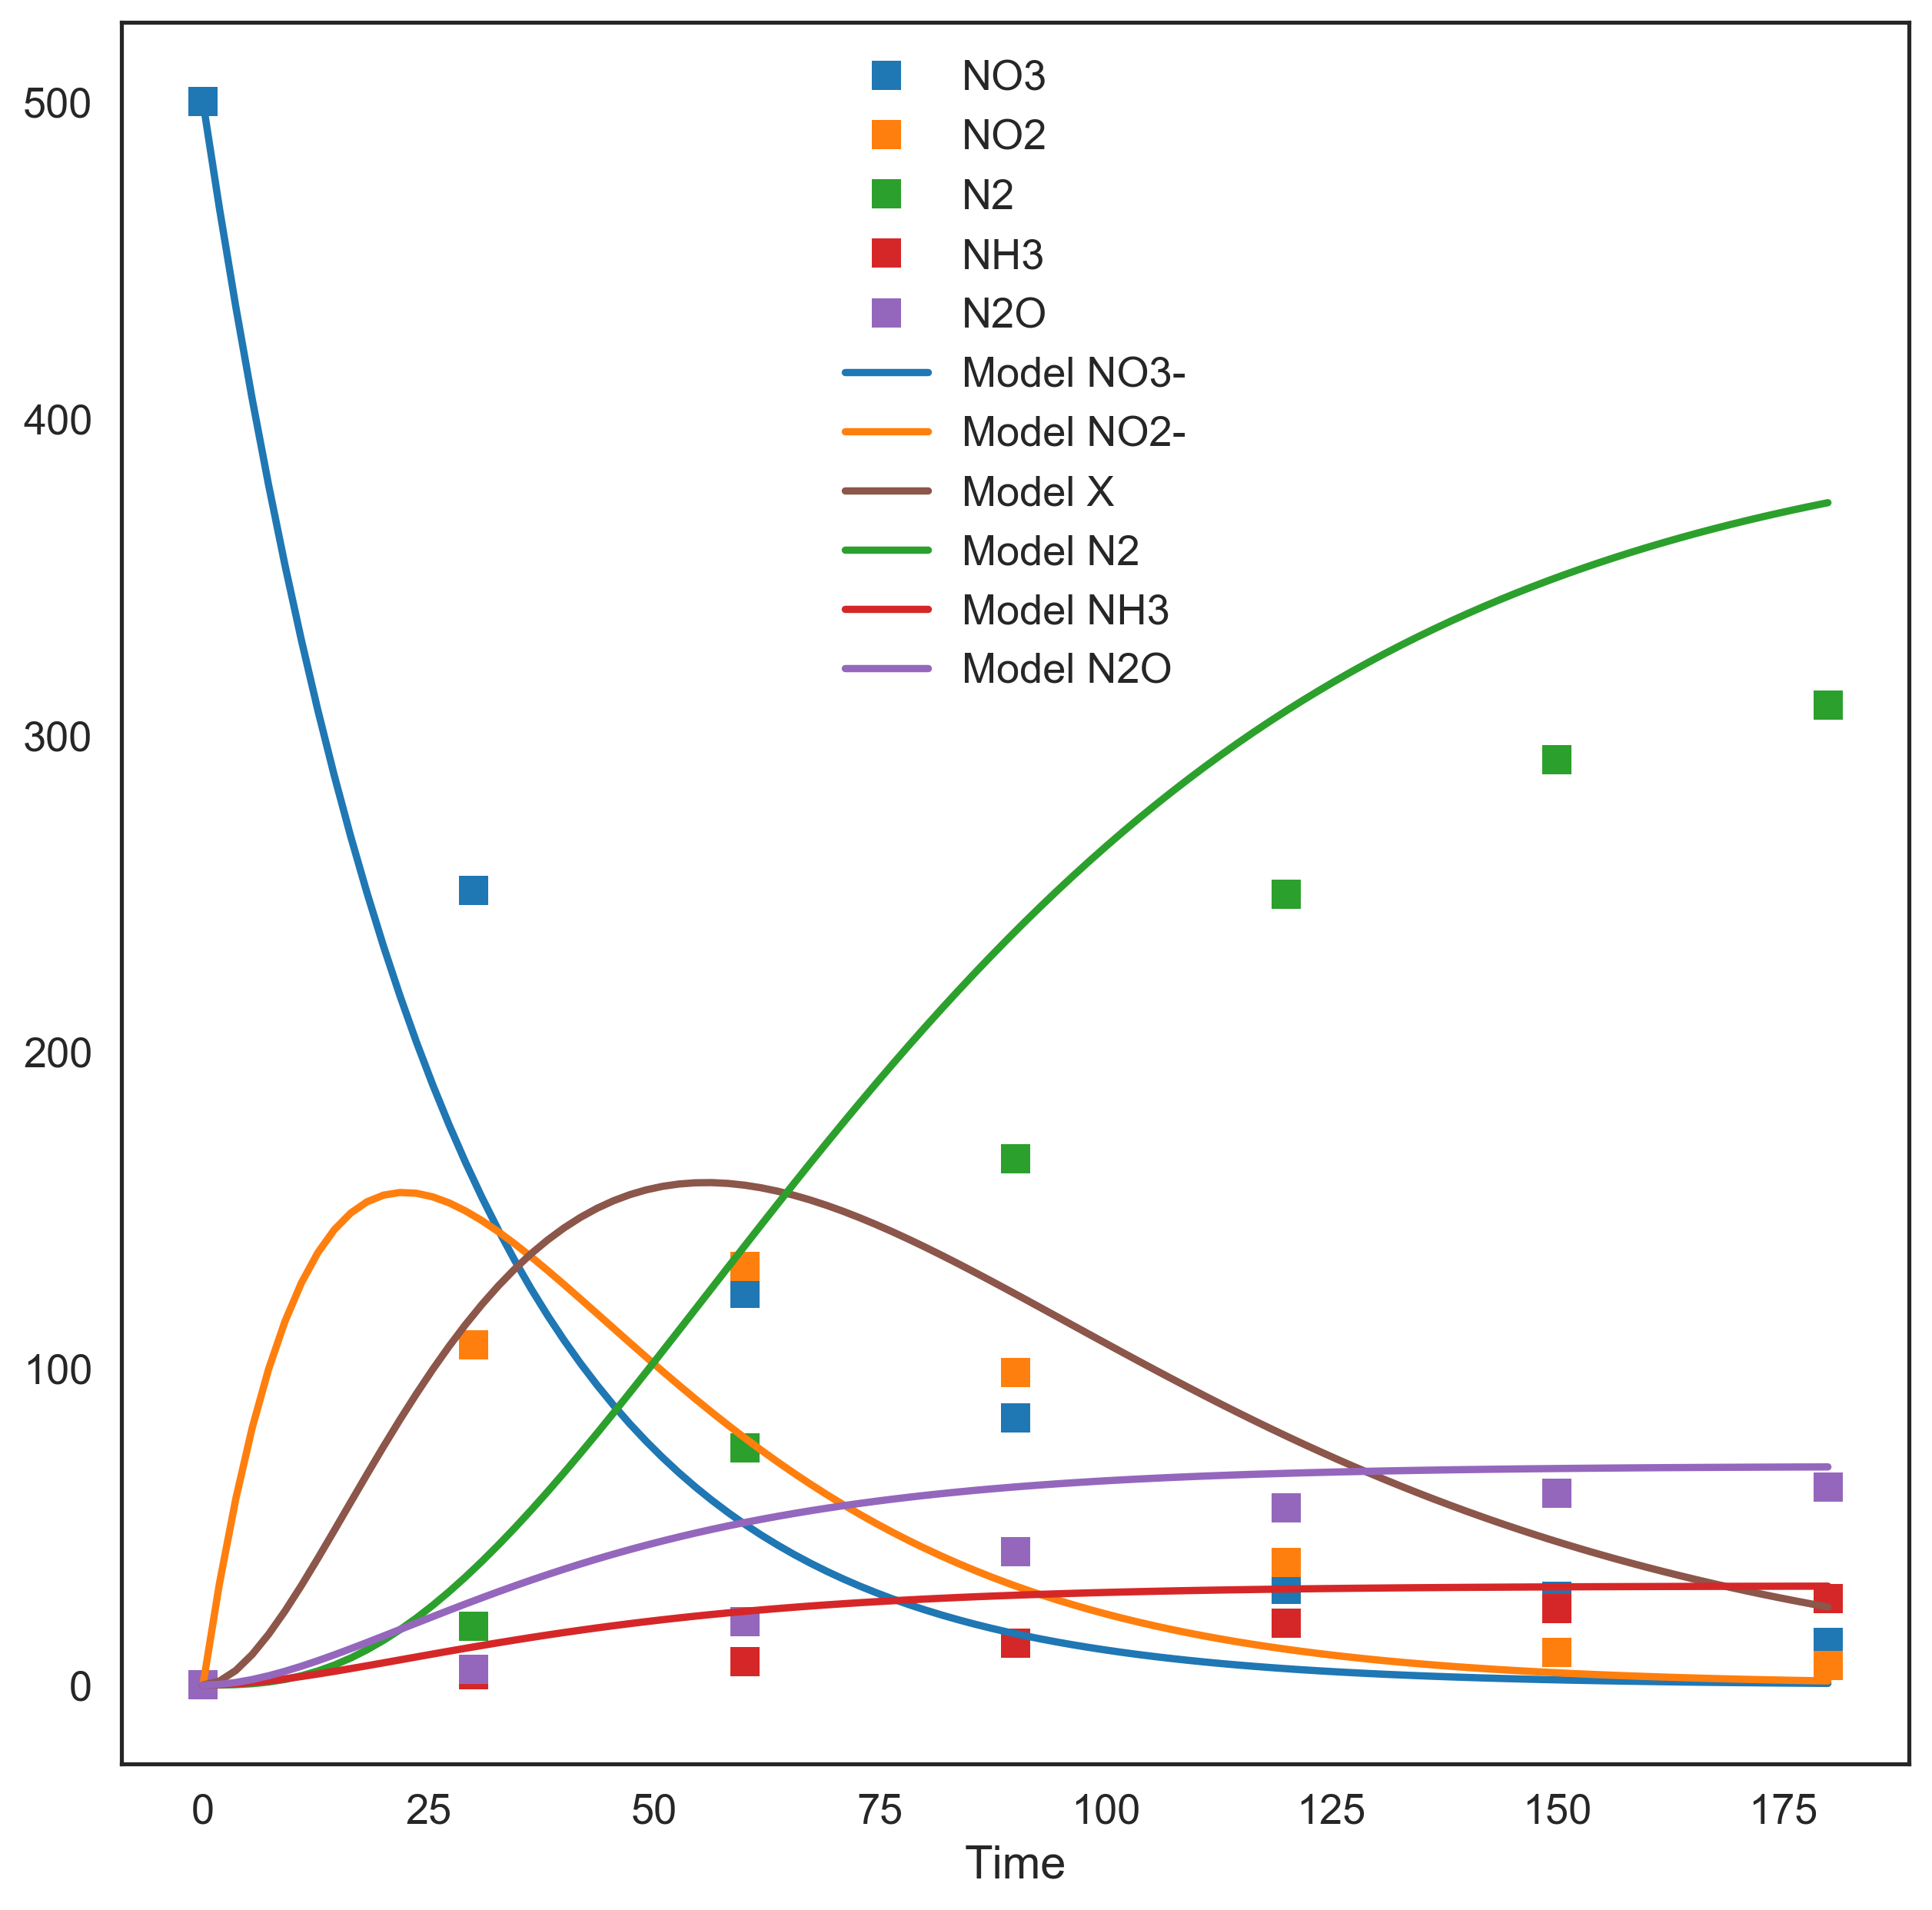

In [10]:
x = res.x
t = np.linspace(0, 180, 100)
x1 = np.array([1.359, 1.657, 1.347, -.16, -1.01])
Yp = Z(x, t)

fig, ax = plt.subplots(figsize=(10, 10))
catalysis_data.plot(ax=ax, style='s')
ax.plot(t, Yp[:, 0], color=sns.color_palette()[0], label='Model NO3-')
ax.plot(t, Yp[:, 1], color=sns.color_palette()[1], label='Model NO2-')
ax.plot(t, Yp[:, 2], color=sns.color_palette()[5], label='Model X')
ax.plot(t, Yp[:, 3], color=sns.color_palette()[2], label='Model N2')
ax.plot(t, Yp[:, 4], color=sns.color_palette()[3], label='Model NH3')
ax.plot(t, Yp[:, 5], color=sns.color_palette()[4], label='Model N2O')
plt.legend();

### Questions

+ Are you satisfied with the above model calibration?
+ Rerun the code. Does the algorithm always work? Do you find exactly the same $x$?
+ Start from an initial $x$ that is very far away from the zero. Like all 10's. What do you find?
+ What is the average number of function evaluations that you need (see ``nfev`` as reported when we print ``res``)? Can this method be easily applied to expensive models?

## Estimating the Derivatives
### Automatic Differentiation
If you have access to the source code producing $L(x)$, including all details of your model $f(x)$, you could use one of the automatic differentiation methodologies.
These see your source code as a mathematical function and they attemp to differntiate it directly using the chain rule.
We are not using any of those because they do require a little bit of low-level coding.

### Analytical Differentiation
Let's use the chain rule to take the derivative of $L(x)$ with respect to $x_i$.
We have:
$$
\begin{array}{ccc}
\frac{\partial L(x,y)}{\partial x_i} &=& \frac{\partial \ell(f(x),y)}{\partial x_i}\\
&=& \sum_{j=1}^m \frac{\partial \ell(f(x),y)}{\partial f_j}\frac{\partial f_j(x)}{\partial x_i}.
\end{array}
$$
For the square loss, we get:
$$
\begin{array}{ccc}
\frac{\partial L(x,y)}{\partial x_i} &=& \frac{\partial \frac{1}{2}\parallel f(x)-y\parallel_2^2}{\partial x_i}\\
&=& \sum_{j=1}^m \left(f_j(x)-y_j\right)\frac{\partial f_j(x)}{\partial x_i}.
\end{array}
$$
So, you see that what we really need is the **Jacobian matrix**:
$$
\nabla f(x) = \left(
\begin{array}{ccc}
\frac{\partial f_1(x)}{\partial x_1} & \dots & \frac{\partial f_1(x)}{\partial x_d}\\
\vdots & \ddots & \vdots\\
\frac{\partial f_m(x)}{\partial x_1} & \dots & \frac{\partial f_m(x)}{\partial x_d}
\end{array}
\right)\in\mathbb{R}^{m\times d}.
$$
If your model is dynamical system (or a partial differential equation) you can use the method of adjoints to build it, see [Lecture 15](./hadnout_15.ipynb).
We will give a brief reminder below.

## Example: The Adjoint of the Catalysis Problem

We have already shown that the dynamical system corresponding to our catalysis model is:
$$
\dot{z} = A(x)z,
$$
with
$$
z(0) = z_0.
$$
Let $z(t;x)$ denote the solution as a function of time and the parameters $x$.
We will derive the a dynamical system that describes the evolution of: 
$$
z_{,j} := \frac{\partial z}{\partial x_j} = \left(\frac{\partial z_1}{\partial x_j},\dots,\frac{\partial z_6}{\partial x_j}\right).
$$
We have from the chain rule:
$$
\begin{array}{ccc}
\dot{z_{,j}} &=& \frac{\partial\dot{z}}{\partial x_j}\\
&=& \frac{\partial}{\partial x_j}\left(A(x)z\right)\\
&=& \frac{\partial A(x)}{\partial x_i}z + A(x)\frac{\partial z}{\partial x_j}
\end{array}
$$
So, for each $j=1,2,\dots,d$, we need to solve the dynamical system:
$$
\dot{z_{,j}} = \frac{\partial A(x)}{\partial x_i}z + A(x)z_{,j},
$$
with initial conditions:
$$
z_{,j}(0) = \frac{\partial z_0}{\partial x_j}.
$$
So, we see that we need to solve 6 additional dynamical systems that depend on the solution of the original one.
They are completly independent.
The implementation is a little bit involved. We are going to import the code from a source file.
We are using the implementation from [(Tsilifis et al., 2015)](http://verification.asmedigitalcollection.asme.org/article.aspx?articleid=2534444).
The files are in this repository.

In [11]:
from demos.catalysis import CatalysisModel
solver = CatalysisModel()  # This works with the k's.

# Let's define the loss function
def L_with_jac(x, y):
    k = np.exp(x) / 180.
    sol = solver(k)
    y = y / 500.
    f = sol['f'][0][5:] / 500
    dfdk = sol['f_grad'][0][5:, :] / 500.
    dfdx = np.einsum('ij,j->ij', dfdk, k)
    tmp = (f - y)
    dLdx = np.einsum('ij,i->j', dfdx, tmp)
    L = 0.5 * np.sum(tmp ** 2)
    return L, dLdx

# Never trust yourself when you are implementing derivatives.
# It's always a good idea to test it.
def f_test(x, y):
    return L_with_jac(x, y)[0]

print 'numerical derivative:'
print scipy.optimize.approx_fprime(x, f_test, 1e-6, y)
print 'analytical derivative:'
print L_with_jac(x, y)[1]

numerical derivative:
[ 0.22789289  0.11728396  0.11690249 -0.02029151 -0.01224872]
analytical derivative:
[ 0.22789079  0.11728329  0.11690359 -0.02029134 -0.01224642]


In [12]:
# They look fine, let's now solve the problem again using the adjoint derivative:
# Initial guess for x
x0 = np.random.randn(5)
#x0 = 10 * np.ones(5)

# Optimize
res = scipy.optimize.minimize(L_with_jac, x0, jac=True, args=(y))

print res

      fun: 0.007413777380275439
 hess_inv: array([[  1.64703200e+00,   4.13625058e-01,  -2.54859509e+00,
         -4.98400861e-01,  -6.78681469e-02],
       [  4.13625058e-01,   8.28024342e+00,  -7.95851942e+00,
          3.48374080e+00,   2.18461197e+00],
       [ -2.54859509e+00,  -7.95851942e+00,   1.99141361e+01,
          4.17202228e+00,   8.09506124e+00],
       [ -4.98400861e-01,   3.48374080e+00,   4.17202228e+00,
          2.13656531e+01,   3.91428005e+00],
       [ -6.78681469e-02,   2.18461197e+00,   8.09506124e+00,
          3.91428005e+00,   8.96635069e+01]])
      jac: array([ -9.89847859e-08,   4.26871864e-06,   6.17798458e-07,
        -1.06357828e-06,  -1.12775406e-06])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 29
     njev: 32
   status: 0
  success: True
        x: array([ 1.35942998,  1.65883463,  1.3457432 , -0.16053307, -1.04881209])


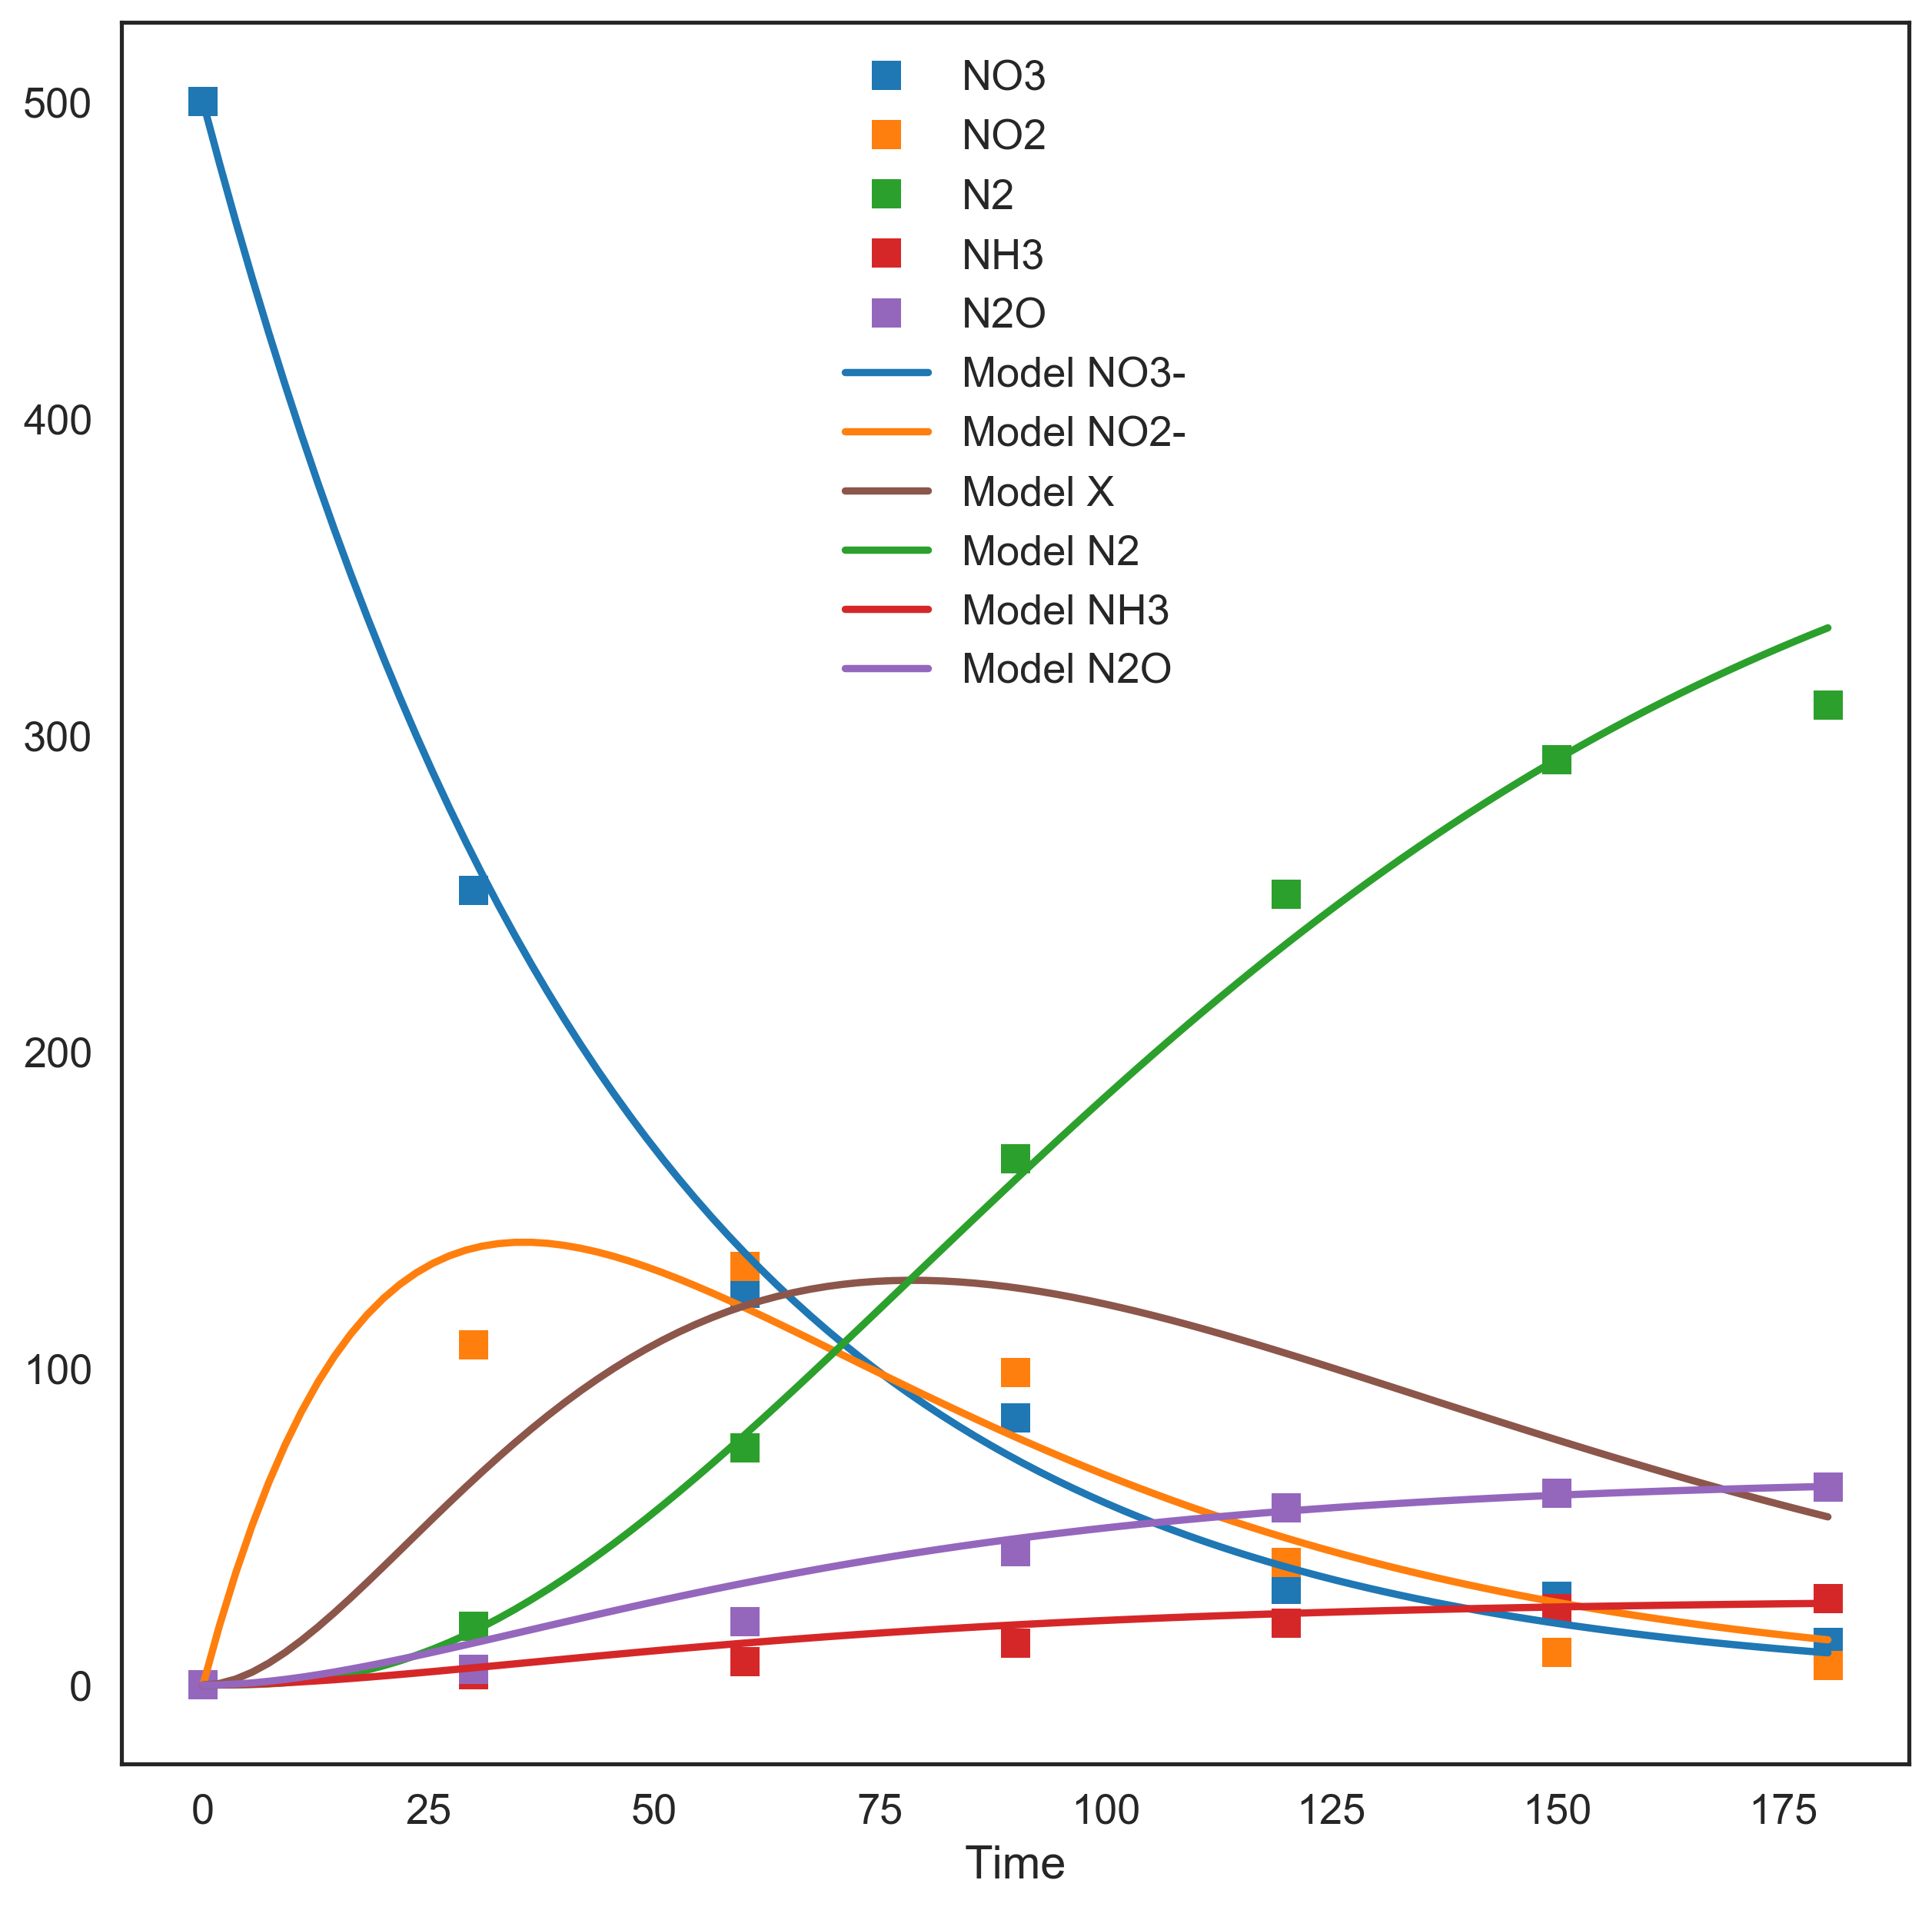

In [13]:
x = res.x
t = np.linspace(0, 180, 100)
x1 = np.array([1.359, 1.657, 1.347, -.16, -1.01])
Yp = Z(x, t)

fig, ax = plt.subplots(figsize=(10, 10))
catalysis_data.plot(ax=ax, style='s')
ax.plot(t, Yp[:, 0], color=sns.color_palette()[0], label='Model NO3-')
ax.plot(t, Yp[:, 1], color=sns.color_palette()[1], label='Model NO2-')
ax.plot(t, Yp[:, 2], color=sns.color_palette()[5], label='Model X')
ax.plot(t, Yp[:, 3], color=sns.color_palette()[2], label='Model N2')
ax.plot(t, Yp[:, 4], color=sns.color_palette()[3], label='Model NH3')
ax.plot(t, Yp[:, 5], color=sns.color_palette()[4], label='Model N2O')
plt.legend();

### Questions

+ Are you satisfied with the above model calibration?
+ Does it payoff to get analytical derivatives?
+ Ok. Derivatives are great. Can you think of way to get them using without messing too much with the solver? 

## Shortcomings of the Classic Approach

There are several shorcomings of the classical approach to model calibration which we will remedy in the next lecture.
Here we briefly mention some:

+ The problems are ill-posed. Solutions may not exist. More than one solutions may exist.
+ No apparent way to quantify uncertainties.
+ No systematic way to account for prior knowledge.